In [21]:
from __future__ import print_function
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as trns
import torchvision.datasets as dset
# import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [22]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [23]:
# dynamic features first
len_dynamic = 6
len_static = 5
num_dynamic_feat = 3


In [24]:
# define dataset
class Credit_Card_Dataset(Dataset):
    def __init__(self, csv_filename):
        self.df = pd.read_csv(csv_filename)
        self.df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
    
    def __getitem__(self, index):
        feat = self.df.iloc[index][['PAY_%d' % i for i in range(1, 7)]
                          + ['BILL_AMT%d' % i for i in range(1, 7)]
                          + ['PAY_AMT%d' % i for i in range(1, 7)]
                          + ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
                         ].to_numpy(dtype=np.float32)
        
        label = int(self.df.iloc[index]['default.payment.next.month'])
        
        return feat, label
    
    def __len__(self):
        return len(self.df)


In [25]:
batch_size = 256
# dataset
train_dataset = Credit_Card_Dataset('UCI_Credit_Card.csv')
# test_dataset = Credit_Card_Dataset('UCI_Credit_Card.csv')

# split train test data
test_split = 0.2

indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
split = int(np.floor(test_split * len(train_dataset)))

train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


In [26]:
# dataloader
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          sampler=train_sampler)
test_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         num_workers=2,
                         sampler=test_sampler)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv = nn.Sequential( # (m, num_dynamic_feat, len_dynamic) = (-1, 2, 6)
                        nn.Conv1d(num_dynamic_feat, 16, 2), # (m, 8, len_dynamic - 1) = (-1, 8, 5)
                        nn.BatchNorm1d(16),
                        nn.ReLU(),
                        # nn.Conv1d(8, 16, 2),
                        # nn.BatchNorm1d(16),
                        # nn.ReLU(),
                        nn.Flatten(), # (m, 16, len_dynamic - 1 - 1) = (-1, 16, 4)
                    )
        
        self.fc = nn.Sequential(
                        nn.Linear((len_dynamic - 1) * 16 + len_static, 2),
                        nn.BatchNorm1d(2),
                        nn.ReLU(),
                        # nn.Sigmoid(),
                    )
        pass
    
    def forward(self, x):
        dynamic_feat = x[:, :num_dynamic_feat * len_dynamic].view(-1, num_dynamic_feat, len_dynamic)
        static_feat = x[:, num_dynamic_feat * len_dynamic:]
        
        latent = self.conv(dynamic_feat)
        output = self.fc(torch.cat((latent, static_feat), dim=1))
        
        return output


In [28]:
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv1d(3, 16, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Flatten()
  )
  (fc): Sequential(
    (0): Linear(in_features=85, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [29]:
# criterion = nn.BCELoss()
weight = torch.tensor([100/78, 100/22], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(model.parameters(), lr = 0.005)

In [30]:
train_acc = []
train_loss = []
test_acc = []

In [31]:
epochs = 50

In [32]:
# train
model.train()
for epoch in range(epochs):
    #iter_loss = 0.0
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_test = 0
    total_test = 0
    
    for i, data in enumerate(train_loader):
        # get input
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # calculate train acc
        _, predicted = torch.max(outputs, 1)
        correct_train += torch.sum(torch.eq(labels.view(-1), predicted.view(-1)))
        total_train += labels.view(-1).size(0)
        
        # calculate test acc
#         with torch.no_grad():
#             model.eval()
#             for data in test_loader:
#                 inputs, labels = data[0].to(device), data[1].to(device)
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs, 1)
#                 correct_test += torch.sum(torch.eq(labels.view(-1), predicted.view(-1)))
#                 total_test += labels.view(-1).size(0)
#             model.train()
        
        # print statistics
        epoch_loss += loss.item()
        
        pass
    
    train_acc.append(correct_train.item() / total_train)
    # test_acc.append(correct_test.item() / total_test)
    train_loss.append(epoch_loss / len(train_loader))
    
    # print('[epoch: %3d] loss: %.5f, train acc: %.5f, test acc: %.5f' % (epoch + 1, train_loss[-1], train_acc[-1], test_acc[-1]))
    print('[epoch: %3d] loss: %.5f, train acc: %.5f' % (epoch + 1, train_loss[-1], train_acc[-1]))
    
    pass
    
print('Finished Training')

[epoch:   1] loss: 0.74893, train acc: 0.50242
[epoch:   2] loss: 0.72401, train acc: 0.62171
[epoch:   3] loss: 0.69568, train acc: 0.73513
[epoch:   4] loss: 0.69334, train acc: 0.77379
[epoch:   5] loss: 0.69323, train acc: 0.77763
[epoch:   6] loss: 0.69318, train acc: 0.77850
[epoch:   7] loss: 0.69317, train acc: 0.77929
[epoch:   8] loss: 0.69316, train acc: 0.77954
[epoch:   9] loss: 0.69316, train acc: 0.77979
[epoch:  10] loss: 0.69316, train acc: 0.77979
[epoch:  11] loss: 0.69315, train acc: 0.78004
[epoch:  12] loss: 0.69315, train acc: 0.78000
[epoch:  13] loss: 0.69315, train acc: 0.78000
[epoch:  14] loss: 0.69315, train acc: 0.78004
[epoch:  15] loss: 0.69315, train acc: 0.78008
[epoch:  16] loss: 0.69315, train acc: 0.78008
[epoch:  17] loss: 0.69315, train acc: 0.78012
[epoch:  18] loss: 0.69315, train acc: 0.78017
[epoch:  19] loss: 0.69315, train acc: 0.78017
[epoch:  20] loss: 0.69315, train acc: 0.78017
[epoch:  21] loss: 0.69315, train acc: 0.78017
[epoch:  22] 

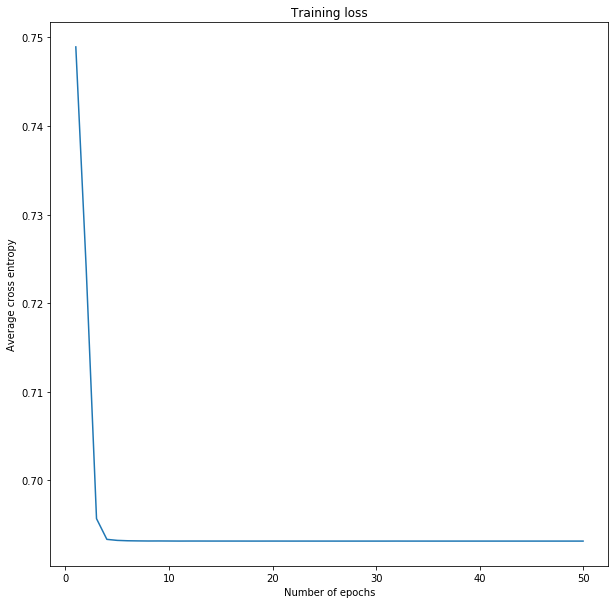

In [33]:
plt.figure(figsize=(10, 10))
plt.axes(title = 'Training loss', xlabel = 'Number of epochs', ylabel = 'Average cross entropy')
plt.plot(range(1, len(train_loss) + 1), train_loss)
# plt.savefig('training_loss.png')
plt.show()

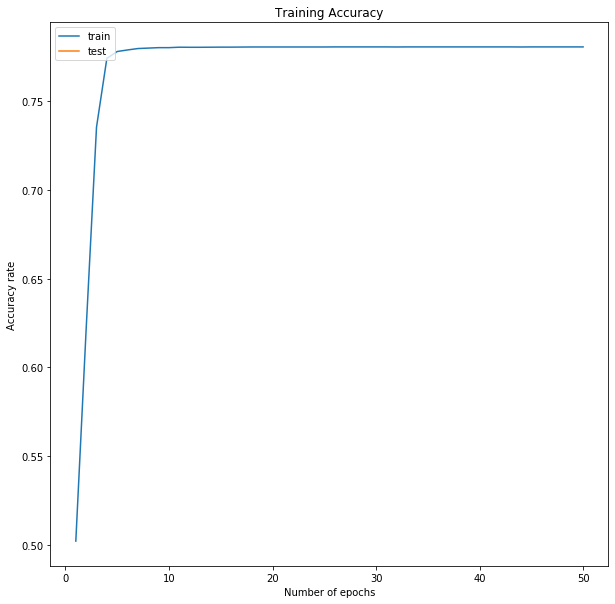

In [34]:
plt.figure()
plt.gcf().set_size_inches(10, 10)
plt.axes(title = 'Training Accuracy', xlabel = 'Number of epochs', ylabel = 'Accuracy rate')
plt.plot(range(1, len(train_acc) + 1), train_acc, label = 'train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label = 'test')
plt.legend(loc = 'upper left')
# plt.savefig('train_test_acc.png')
plt.show()

In [35]:
classes = ['0', '1']
class_correct = [0 for _ in range(len(classes))]
class_total = [0 for _ in range(len(classes))]
confusion_matrix = torch.zeros(len(classes), len(classes)).to(device)

with torch.no_grad():
    model.eval()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))
c_tr = confusion_matrix.cpu().numpy()
df = pd.DataFrame(c_tr, index = ['0', '1'], columns=['0', '1'])
df

tensor([[18725.,     0.],
        [ 5275.,     0.]], device='cuda:1')
tensor([1., 0.], device='cuda:1')


,0,1
0,18725.0,0.0
1,5275.0,0.0


In [36]:
classes = ['0', '1']
class_correct = [0 for _ in range(len(classes))]
class_total = [0 for _ in range(len(classes))]
confusion_matrix = torch.zeros(len(classes), len(classes)).to(device)

with torch.no_grad():
    model.eval()
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))
c_te = confusion_matrix.cpu().numpy()
df = pd.DataFrame(c_te, index = ['0', '1'], columns=['0', '1'])
df

tensor([[4639.,    0.],
        [1361.,    0.]], device='cuda:1')
tensor([1., 0.], device='cuda:1')


,0,1
0,4639.0,0.0
1,1361.0,0.0
